# LSTM track-finding model for 2D detector layers

In this notebook we extend the method of the "simple" LSTM on 1D detector layer data to 2D detector layers, using the data functionality developed in the DataGen2D notebook.

In [1]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers

# Magic
%matplotlib notebook

Using TensorFlow backend.


## Utilities

In [22]:
def draw_layer(ax, data, title=None, **kwargs):
    """Draw one detector layer as an image"""
    ax.imshow(data.T, interpolation='none', aspect='auto',
              origin='lower', **kwargs)
    if title is not None:
        ax.set_title(title)

def draw_layers(event, ncols=5, figsize=(9.5, 4.5)):
    """Draw each detector layer as a grid of images"""
    num_layers = event.shape[0]
    nrows = math.ceil(float(num_layers)/ncols)
    plt.figure(figsize=figsize)
    for ilay in range(num_layers):
        ax = plt.subplot(nrows, ncols, ilay+1)
        title = 'layer %i' % ilay
        draw_layer(ax, event[ilay], title=title)
    plt.tight_layout()

def draw_train_history(history, figsize=(9.5, 4.5)):
    """Make plots of training and validation losses and accuracies"""
    plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.epoch, history.history['acc'], label='Training set')
    plt.plot(history.epoch, history.history['val_acc'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.title('Training accuracy')
    plt.legend()
    plt.tight_layout()

In [3]:
def gen_noise_2d(shape, prob=0.1, seed_layers=0):
    noise = (np.random.random_sample(shape) < prob).astype(np.int8)
    noise[:,:seed_layers,:,:] = 0
    return noise

def gen_straight_tracks_2d(n, num_layers, layer_size):
    # Initialize the data
    data = np.zeros((n, num_layers, layer_size, layer_size),
                    dtype=np.float32)
    # Sample the entry and exit points for tracks
    entry_points = np.random.uniform(0, layer_size, size=(n, 2))
    exit_points = np.random.uniform(0, layer_size, size=(n, 2))
    # Calculate slope parameters
    slopes = (exit_points - entry_points) / float(num_layers - 1)
    # Calculate hit positions and fill hit data
    xhits = np.zeros(num_layers, dtype=np.int)
    yhits = np.zeros(num_layers, dtype=np.int)
    idx = np.arange(num_layers)
    for ievt in range(n):
        xhits[:] = slopes[ievt,0]*idx + entry_points[ievt,0]
        yhits[:] = slopes[ievt,1]*idx + entry_points[ievt,1]
        data[ievt,idx,xhits,yhits] = 1   
    return data

def gen_bkg_tracks_2d(num_event, num_layers, layer_size,
                      avg_bkg_tracks=3, seed_layers=0):
    num_bkg_tracks = np.random.poisson(avg_bkg_tracks, num_event)
    bkg_tracks = np.zeros((num_event, num_layers, layer_size, layer_size),
                          dtype=np.float32)
    for ievt in range(num_event):
        ntrk = num_bkg_tracks[ievt]
        bkg_tracks[ievt] = sum(gen_straight_tracks_2d(ntrk, num_layers, layer_size))
    bkg_tracks[:,:seed_layers,:,:] = 0
    return bkg_tracks

In [4]:
def flatten_layers(data):
    """Flattens each 2D detector layer into a 1D array"""
    return data.reshape((data.shape[0], data.shape[1], -1))

def flat_to_2d(data, det_width):
    """Expands the flattened layers to original (width x width)"""
    return data.reshape((data.shape[0], data.shape[1], det_width, det_width))

In [5]:
def top_prediction_2d(data):
    """Picks out the top hit prediction from each layer"""
    output = np.zeros_like(data)
    maxcols = np.argmax(data, axis=2)
    rowidx = np.arange(data.shape[3])
    for ievt in range(data.shape[0]):
        for ilay in range(data.shape[1]):
            #print('Event, layer:', ievt, ilay)
            maxrow = np.argmax(data[ievt, ilay, maxcols[ievt, ilay], rowidx])
            maxcol = maxcols[ievt, ilay, maxrow]
            #print(maxcol, maxrow)
            output[ievt, ilay, maxcol, maxrow] = 1
    return output

def calc_accuracy(preds, target):
    """Calculates hit prediction accuracy"""
    top_preds = top_prediction_2d(preds)
    # FINISH ME

## Configuration

In [6]:
num_event = 100000
num_layers = 10
num_seed_layers = 3
layer_size = 10
avg_bkg_tracks = 2
shape = (num_event, num_layers, layer_size, layer_size)
det_shape = shape[1:]

## Data generation

In [7]:
# Signal tracks
sig_tracks = gen_straight_tracks_2d(num_event, num_layers, layer_size)
# Background tracks
bkg_tracks = gen_bkg_tracks_2d(num_event, num_layers, layer_size,
                               avg_bkg_tracks=avg_bkg_tracks,
                               seed_layers=num_seed_layers)
# Noise
noise = gen_noise_2d(shape, prob=0.01, seed_layers=num_seed_layers)

# Full events
events = sig_tracks + bkg_tracks + noise
events[events > 1] = 1

# Print data sizes
print('Sizes of arrays')
print('  events:     %g MB' % (events.dtype.itemsize * events.size / 1e6))
print('  sig_tracks: %g MB' % (sig_tracks.dtype.itemsize * sig_tracks.size / 1e6))
print('  bkg_tracks: %g MB' % (bkg_tracks.dtype.itemsize * bkg_tracks.size / 1e6))
print('  noise:      %g MB' % (noise.dtype.itemsize * noise.size / 1e6))

Sizes of arrays
  events:     400 MB
  sig_tracks: 400 MB
  bkg_tracks: 400 MB
  noise:      100 MB


<IPython.core.display.Javascript object>


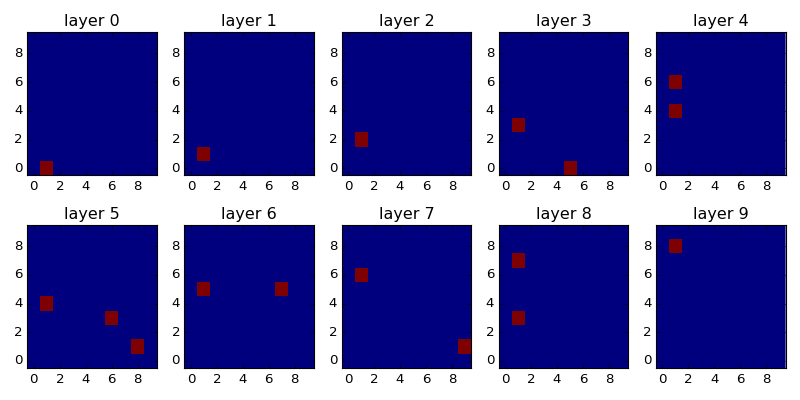

In [8]:
# Visualize one event
draw_layers(events[0], figsize=(10, 5))

## Define the model

In [10]:
# THIS DOESN'T WORK
#def build_model(det_shape, num_hidden=100,
#                loss='categorical_crossentropy',
#                optimizer='Nadam', metrics=['accuracy']):
#    det_depth, det_width, _ = det_shape
#    inputs = layers.Input(shape=(det_depth-1, det_width, det_width))
#    inputs_flat = layers.Reshape((det_depth-1, det_width**2))(inputs)
#    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs_flat)
#    outputs_flat = layers.TimeDistributed(layers.Dense(det_width**2, activation='softmax'))(hidden)
#    outputs = layers.Reshape((det_depth-1, det_width, det_width))(outputs_flat)
#    model = models.Model(input=inputs, output=outputs)
#    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
#    return model

def build_model(det_shape, num_hidden=100,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    det_depth, det_width, _ = det_shape
    # Model inputs
    inputs = layers.Input(shape=(det_depth-1, det_width*det_width))
    # LSTM layer
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    # Output fully-connected layer
    outputs = layers.TimeDistributed(layers.Dense(det_width**2, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

def build_deep_model(det_shape, num_hidden=100,
                     loss='categorical_crossentropy',
                     optimizer='Nadam', metrics=['accuracy']):
    det_depth, det_width, _ = det_shape
    # Model inputs
    inputs = layers.Input(shape=(det_depth-1, det_width*det_width))
    # Input fully-connected layer
    hidden = layers.TimeDistributed(layers.Dense(num_hidden, activation='relu'))(inputs)
    # LSTM layer
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(hidden)
    # Output fully-connected layers
    hidden = layers.TimeDistributed(layers.Dense(num_hidden, activation='relu'))(hidden)
    outputs = layers.TimeDistributed(layers.Dense(det_width**2, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## Training

In [16]:
# Configure the training
num_hidden = 200
batch_size = 500
num_epoch = 10
valid_frac = 0.2

train_input = flatten_layers(sig_tracks[:,:-1,:,:])
train_target = flatten_layers(sig_tracks[:,1:,:,:])
train_preds = flatten_layers(np.zeros_like(sig_tracks))

In [17]:
# Build the model
model = build_model(det_shape, num_hidden=num_hidden)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 9, 100)        0                                            
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 9, 200)        240800      input_3[0][0]                    
____________________________________________________________________________________________________
timedistributed_3 (TimeDistribute(None, 9, 100)        20100       lstm_3[0][0]                     
Total params: 260900
____________________________________________________________________________________________________


In [18]:
# Train the model
history = model.fit(train_input, train_target,
                    batch_size=batch_size, nb_epoch=num_epoch,
                    validation_split=valid_frac)

# Get all of the training data predictions
train_preds[:,1:,:] = model.predict(train_input, batch_size=batch_size)

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 7s - loss: 2.8694 - acc: 0.3003 - val_loss: 1.8639 - val_acc: 0.4311
Epoch 2/10
80000/80000 [==============================] - 7s - loss: 1.5494 - acc: 0.4844 - val_loss: 1.3632 - val_acc: 0.5175
Epoch 3/10
80000/80000 [==============================] - 7s - loss: 1.2784 - acc: 0.5306 - val_loss: 1.2250 - val_acc: 0.5400
Epoch 4/10
80000/80000 [==============================] - 8s - loss: 1.1770 - acc: 0.5514 - val_loss: 1.1584 - val_acc: 0.5504
Epoch 5/10
80000/80000 [==============================] - 7s - loss: 1.1260 - acc: 0.5612 - val_loss: 1.1046 - val_acc: 0.5667
Epoch 6/10
80000/80000 [==============================] - 7s - loss: 1.0927 - acc: 0.5683 - val_loss: 1.0845 - val_acc: 0.5686
Epoch 7/10
80000/80000 [==============================] - 8s - loss: 1.0725 - acc: 0.5726 - val_loss: 1.0711 - val_acc: 0.5712
Epoch 8/10
80000/80000 [==============================] - 8s 

<IPython.core.display.Javascript object>


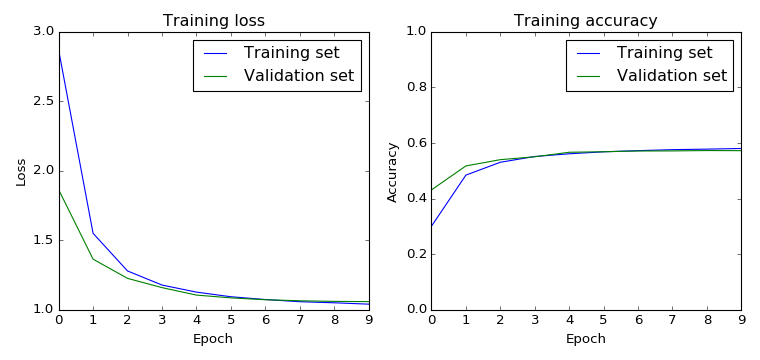

In [23]:
draw_train_history(history)

<IPython.core.display.Javascript object>


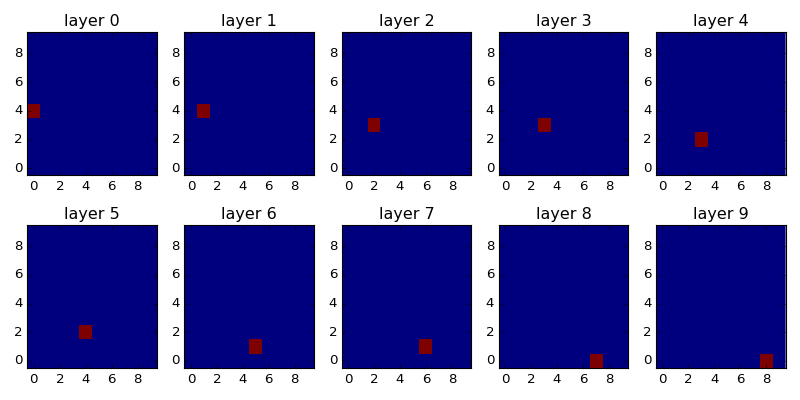

In [20]:
# Visualize one event
disp_idx = 6
draw_layers(sig_tracks[disp_idx], figsize=(10, 5))

<IPython.core.display.Javascript object>


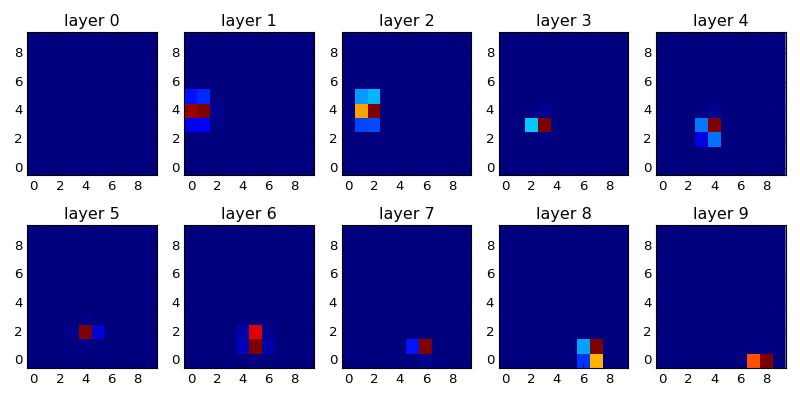

In [21]:
preds = flat_to_2d(train_preds, layer_size)
draw_layers(preds[disp_idx], figsize=(10, 5))